In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_validate

# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#multiclass imports
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier #Will identify the maority calss base line, model needs to do better then the baseline

from statistics import mean
# to reduce randomness then you put the seed
np.random.seed(42)

from ArtificialImmuneSystem import *
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import KFold

from tabulate import tabulate
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
dataset = 'Data\hcv_data_split.csv'
df = pd.read_csv(dataset)

#df = df.drop('Unnamed: 0', axis=1)

In [3]:
print(f"Data shape: \n{df.shape}\n")
print(f"Data size: \n{df.size}\n")
print(f"Data ndim: \n{df.ndim}\n")
print("_____________________________________________\n")
print(f"Old Class Distribution: {Counter(df['category'])}")

Data shape: 
(615, 14)

Data size: 
8610

Data ndim: 
2

_____________________________________________

Old Class Distribution: Counter({0: 540, 1: 75})


In [4]:
features =df.copy()
features = features.drop(['category'],axis=1)



In [5]:
kf = KFold(n_splits=5)
dataAIS = []
dataSMOTE = []
dataBase = []
data = []
fold = 0

for result in kf.split(df):
    fold = fold+1

    #Print the shape of the train and test set
    data_train = df.iloc[result[0]]
    data_test =  df.iloc[result[1]]

    label_train = data_train.copy()
    label_train = label_train.drop(['Age','Sex','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT','split'],axis=1) #Drop all except category for the train df
 
    label_test = data_test.copy()
    label_test = label_test.drop(['Age','Sex','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT','split'],axis=1) #Drop all except category for the train df
   
    train_df = data_train.copy()
    train_df = train_df.drop(['category'],axis=1)
    numerical_attribute_train = train_df.drop(['split','Sex'],axis=1)
    
    num_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('std_scaler', StandardScaler()),
    ])

    num_attribs = list(numerical_attribute_train)
    cat_attribs = ["Sex"]

    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])


    data_prepared_train = pd.DataFrame(full_pipeline.fit_transform(train_df),columns=train_df.columns, index=train_df.index)
    rejoin_train = pd.concat([data_prepared_train,label_train],axis=1)

    test_df = data_test.drop(['category'],axis=1) #We chose KNN for the actual impuation
    num_pipeline_test = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('std_scaler', StandardScaler()),
    ])
    cat_attribs_test = ['split',"Sex"]
    numerical_attr_test = test_df.drop(['Sex'],axis=1)
    numerical_attr_test = list(numerical_attr_test)

    full_pipeline_test = ColumnTransformer([
        ("num", num_pipeline_test, numerical_attr_test),
        ("cat", OneHotEncoder(), cat_attribs_test),
    ])

    data_prepared_test = pd.DataFrame(full_pipeline.fit_transform(test_df),columns=test_df.columns, index=test_df.index)
    rejoin_test = pd.concat([data_prepared_test,label_test],axis=1)
   
    
    data_train_AIS = rejoin_train.copy()
    data_train_SMOTE = rejoin_train.copy()

    data_train_AIS = data_train_AIS.drop(['split'],axis=1)
    data_train_SMOTE = data_train_SMOTE.drop(['split'],axis=1)

    data_train = rejoin_train.copy()
    data_test = rejoin_test.copy()

    data_train = data_train.drop(['split'],axis=1)
    data_test = data_test.drop(['split'],axis=1)
    #Create an oversampling object
   
    oversample = SMOTE()
    randomForest = RandomForestClassifier()
    logisticRegression = LogisticRegression()
    kNeighbors = KNeighborsClassifier()
    gradientBoosting = GradientBoostingClassifier()


    oversample_AIS = ArtificialImmuneSystem()
    #Oversample and add to the dataframe to fix the class imbalance
    logisticRegression = LogisticRegression()
    st = time.time()
    x_over, y_over = oversample.fit_resample(data_train_SMOTE.drop(["category"], axis=1), data_train_SMOTE.drop(data_train_SMOTE.columns[0:-1],axis=1))
    elapsed_time_SMOTE = time.time() - st

    st = time.time()
    input_x_over_AIS, y_over_AIS = oversample_AIS.AIS_Resample(data_train_AIS.drop(["category"], axis=1), data_train_AIS.drop(data_train_AIS.columns[0:-1],axis=1), max_rounds = 10, stopping_cond = 5, model = randomForest,K_folds = 5,scorer = 'f1',min_change = 0.005, use_lof = True)
    elapsed_time_AIS = time.time() - st

    smote_df = pd.concat([x_over, y_over], axis=1)
    ais_df = pd.concat([input_x_over_AIS, y_over_AIS], axis=1)

    # print the dimensionality of the oversampled dataset
    #print(f"SMOTE Oversampled Data shape: \n{smote_df.shape}\n")
    #print(f"SMOTE Oversampled Data size: \n{smote_df.size}\n")
    #print(f"SMOTE Oversampled Data ndim: \n{smote_df.ndim}\n")
    #print("_____________________________________________\n")

    # print the dimensionality of the oversampled dataset
    #print(f"AIS Oversampled Data shape: \n{ais_df.shape}\n")
    #print(f"AIS Oversampled Data size: \n{ais_df.size}\n")
    #print(f"AIS Oversampled Data ndim: \n{ais_df.ndim}\n")
    #print("_____________________________________________\n")


    # print the new class distribution using a Counter
    #print(f"New SMOTE Class Distribution: {Counter(smote_df['5'])}")
    #print(f"New AIS Class Distribution: {Counter(ais_df['5'])}")
    ## print the new class distribution using a Counter
    #print(f"Old Class Distribution: {Counter(data_train['5'])}")

    #print("_____________________________________________\n")

    #labelTrainFlat = labels_train.values.ravel()

    #Fit one vs rest Gradient Boosting classification
    gradientBoosting = GradientBoostingClassifier()
    gradientBoosting = gradientBoosting.fit(x_over, y_over.values.ravel())

    gradientBoosting_AIS = GradientBoostingClassifier()
    gradientBoosting_AIS = gradientBoosting.fit(input_x_over_AIS, y_over_AIS.values.ravel())

    gradientBoosting_Base = gradientBoosting.fit(data_train.drop(["category"], axis=1), data_train.drop(data_train.columns[0:-1],axis=1).values.ravel())

    #Fit RandomForestClassifier classification
    randomForest = RandomForestClassifier()
    randomForest = randomForest.fit(x_over,y_over.values.ravel())

    randomForest = RandomForestClassifier()
    randomForest_AIS  = randomForest.fit(input_x_over_AIS,y_over_AIS.values.ravel())

    randomForest_Base = randomForest.fit(data_train.drop(["category"], axis=1), data_train.drop(data_train.columns[0:-1],axis=1).values.ravel())
    #randomForest_Base  = randomForest.fit(data_train.drop(["5"], axis=1), data_train.drop(data_train_AIS.columns[0:-1]).values.ravel())

    #Create a KNeighbors classification object
    kNeighbors = KNeighborsClassifier()
    kNeighbors = kNeighbors.fit(x_over,y_over.values.ravel())

    kNeighbors = KNeighborsClassifier()
    kNeighbors_AIS  = kNeighbors.fit(input_x_over_AIS,y_over_AIS.values.ravel())
    kNeighbors_Base = kNeighbors.fit(data_train.drop(["category"], axis=1), data_train.drop(data_train.columns[0:-1],axis=1).values.ravel())
    #kNeighbors_base  = kNeighbors.fit(data_train.drop(["5"], axis=1), data_train.drop(data_train_AIS.columns[0:-1]).values.ravel())

    #Create an LogisticRegression object
    logisticRegression = LogisticRegression(max_iter=5000)
    logisticRegression = logisticRegression.fit(x_over,y_over.values.ravel())

    logisticRegression = LogisticRegression(max_iter=5000)
    logisticRegression_AIS  = logisticRegression.fit(input_x_over_AIS,y_over_AIS.values.ravel())
    logisticRegression_Base = logisticRegression.fit(data_train.drop(["category"], axis=1), data_train.drop(data_train.columns[0:-1],axis=1).values.ravel())
    #logisticRegression_Base  = logisticRegression.fit(data_train.drop(["5"], axis=1), data_train.drop(data_train_AIS.columns[0:-1]).values.ravel())

    #Set the parameters of GradientBoosting for GridSearchCV
    parametersGradientBoosting = [
        {'learning_rate': [0.10,0.30,0.40],'min_samples_leaf': [4,8,15,20],'min_samples_split': [5,10,15,20], 'n_estimators': [10,30,40,50,60]}
    ]

    #Set the scoring parameters
    scoringX = {"roc_auc": "roc_auc", "bal_accuracy": "balanced_accuracy","accuracy": "accuracy","F1_macro": "f1_macro"}

    #Preform Gridsearch to find best parameters
    grid_searchGradientBoosting = GridSearchCV(gradientBoosting, parametersGradientBoosting, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    grid_searchGradientBoosting_AIS = GridSearchCV(gradientBoosting_AIS, parametersGradientBoosting, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    #grid_searchGradientBoosting_Base = GridSearchCV(gradientBoosting_Base, parametersGradientBoosting, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    #Fit the GradientBoosting 
    grid_searchGradientBoosting.fit(x_over, y_over.values.ravel())
    grid_searchGradientBoosting_AIS.fit(input_x_over_AIS,y_over_AIS.values.ravel())
  
    

    #Print GridSearchCV Results
    
    print(f"Best score GradientBoosting: \n{grid_searchGradientBoosting.best_score_}\n")
    print("_____________________________________________\n")
    
    print(f"Best score GradientBoosting AIS: \n{grid_searchGradientBoosting_AIS.best_score_}\n")

    #Set the parameters of KNeighbors for GridSearchCV
    parametersKNeighbors = [
        {'n_neighbors': [1,5,10,15],'weights':['uniform', 'distance'],'algorithm':['auto'], 'p': [1,5,10]}
    ]

    #Set the scoring parameters
    #scoringX = {"roc_auc": "roc_auc", "bal_accuracy": "balanced_accuracy"}

    #Preform KNeighbors to find best parameters
    grid_searchKNeighbors = GridSearchCV(kNeighbors, parametersKNeighbors, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    grid_searchKNeighbors_AIS = GridSearchCV(kNeighbors_AIS, parametersKNeighbors, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

    #Fit the KNeighbors 
    grid_searchKNeighbors.fit(x_over, y_over.values.ravel())
    grid_searchKNeighbors_AIS.fit(input_x_over_AIS,y_over_AIS.values.ravel())

    #Print GridSearchCV Results
   
    print(f"Best score KNeighbors: \n{grid_searchKNeighbors.best_score_}\n")
    print("_____________________________________________\n")
   
    print(f"Best score KNeighbors AIS: \n{grid_searchKNeighbors_AIS.best_score_}\n")
    
    #Set the parameters of LogisticRegression for GridSearchCV
    parametersLogisticRegression = [
        {'multi_class': ['ovr'],'penalty':['none','l2'], 'C': [1,5,10]}
    ]
    #scoringX = {"roc_auc": "roc_auc", "bal_accuracy": "balanced_accuracy"}

    #Preform LogisticRegression to find best parameters
    grid_searchLogisticRegression = GridSearchCV(logisticRegression, parametersLogisticRegression, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    grid_searchLogisticRegression_AIS = GridSearchCV(logisticRegression_AIS, parametersLogisticRegression, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

    #Fit the LogisticRegression 
    grid_searchLogisticRegression.fit(x_over, y_over.values.ravel())
    grid_searchLogisticRegression_AIS.fit(input_x_over_AIS,y_over_AIS.values.ravel())

    #Print LogisticRegression Results
    
    print(f"Best score Logistic Regression: \n{grid_searchLogisticRegression.best_score_}\n")
    print("_____________________________________________\n")
   
    print(f"Best score Logistic Regression AIS: \n{grid_searchLogisticRegression_AIS.best_score_}\n")

    #Set the parameters of RandomForest for GridSearchCV
    parametersRandomForest = [
        {'n_estimators': [50,100,150,200],'max_depth': [5,10,15,20], 'bootstrap': [True, False],
        'min_samples_split': [0.05,2,5,10], 'max_features': ['sqrt']}
    ]

    #Preform Gridsearch to find best parameters
    grid_searchRandomForest = GridSearchCV(randomForest, parametersRandomForest, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')
    grid_searchRandomForest_AIS = GridSearchCV(randomForest_AIS, parametersRandomForest, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

    #Fit the RandomForest 
    grid_searchRandomForest.fit(x_over, y_over.values.ravel())
    grid_searchRandomForest_AIS.fit(input_x_over_AIS,y_over_AIS.values.ravel())

    #Print GridSearchCV Results

    print(f"Best score RandomForest: \n{grid_searchRandomForest.best_score_}\n")

    print(f"Best score RandomForest AIS: \n{grid_searchRandomForest_AIS.best_score_}\n")

    #Get the results for all classifiers 
    cross_val_resultsGB = grid_searchGradientBoosting.cv_results_
    cross_val_resultsRF = grid_searchRandomForest.cv_results_
    cross_val_resultsLR = grid_searchLogisticRegression.cv_results_
    cross_val_resultsKN = grid_searchKNeighbors.cv_results_

    cross_val_resultsGB_AIS = grid_searchGradientBoosting_AIS.cv_results_
    cross_val_resultsRF_AIS = grid_searchRandomForest_AIS.cv_results_
    cross_val_resultsLR_AIS = grid_searchLogisticRegression_AIS.cv_results_
    cross_val_resultsKN_AIS = grid_searchKNeighbors_AIS.cv_results_


    #Print the results of all classiifiers
    #GBC
    mean_test_roc_aucGB = mean(cross_val_resultsGB['mean_test_roc_auc'])
    mean_test_bal_accuracyGB = mean(cross_val_resultsGB['mean_test_bal_accuracy'])
    
    mean_test_roc_aucGB_AIS = mean(cross_val_resultsGB_AIS['mean_test_roc_auc'])
    mean_test_bal_accuracyGB_AIS = mean(cross_val_resultsGB_AIS['mean_test_bal_accuracy'])
   
    #RFC
    mean_test_roc_aucRF = mean(cross_val_resultsRF['mean_test_roc_auc'])
    mean_test_bal_accuracyRF = mean(cross_val_resultsRF['mean_test_bal_accuracy'])
    
    mean_test_roc_aucRF_AIS = mean(cross_val_resultsRF_AIS['mean_test_roc_auc'])
    mean_test_bal_accuracyRF_AIS = mean(cross_val_resultsRF_AIS['mean_test_bal_accuracy'])
    #LRC
    mean_test_roc_aucLR = mean(cross_val_resultsLR['mean_test_roc_auc'])
    mean_test_bal_accuracyLR = mean(cross_val_resultsLR['mean_test_bal_accuracy'])
    
    mean_test_roc_aucLR_AIS = mean(cross_val_resultsLR_AIS['mean_test_roc_auc'])
    mean_test_bal_accuracyLR_AIS = mean(cross_val_resultsLR_AIS['mean_test_bal_accuracy'])

    #KNC
    mean_test_roc_aucKN = mean(cross_val_resultsKN['mean_test_roc_auc'])
    mean_test_bal_accuracyKN = mean(cross_val_resultsKN['mean_test_bal_accuracy'])
    
    mean_test_roc_aucKN_AIS = mean(cross_val_resultsKN_AIS['mean_test_roc_auc'])
    mean_test_bal_accuracyKN_AIS = mean(cross_val_resultsKN_AIS['mean_test_bal_accuracy'])

    predictions_test_over_GB = grid_searchGradientBoosting.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_RF = grid_searchRandomForest.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_LR = grid_searchLogisticRegression.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_KN = grid_searchKNeighbors.best_estimator_.predict(data_test.drop(["category"],axis=1))

    predictions_test_over_GB_AIS = grid_searchGradientBoosting_AIS.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_RF_AIS = grid_searchRandomForest_AIS.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_LR_AIS = grid_searchLogisticRegression_AIS.best_estimator_.predict(data_test.drop(["category"],axis=1))
    predictions_test_over_KN_AIS = grid_searchKNeighbors_AIS.best_estimator_.predict(data_test.drop(["category"],axis=1))

    predictions_GB = gradientBoosting_Base.predict(data_test.drop(["category"],axis=1))
    predictions_RF = randomForest_Base.predict(data_test.drop(["category"],axis=1))
    predictions_LR = logisticRegression_Base.predict(data_test.drop(["category"],axis=1))
    predictions_KN = kNeighbors_Base.predict(data_test.drop(["category"],axis=1))

    f1_score_GB = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB)
    f1_score_RF = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF)
    f1_score_LR = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR)
    f1_score_KN = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN)

    f1_score_GB_AIS = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB_AIS) 
    f1_score_RF_AIS = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF_AIS)
    f1_score_LR_AIS = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR_AIS)
    f1_score_KN_AIS = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN_AIS)

    f1_score_GB_Base = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_GB)
    f1_score_RF_Base = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_RF)
    f1_score_LR_Base = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_LR)
    f1_score_KN_Base = f1_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_KN)

    geometric_mean_score_GB = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_RF = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_LR = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_KN = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN, labels=None, pos_label=1, average='binary',)

    geometric_mean_score_GB_AIS = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB_AIS, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_RF_AIS = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF_AIS, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_LR_AIS = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR_AIS, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_KN_AIS = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN_AIS, labels=None, pos_label=1, average='binary',)

    geometric_mean_score_GB_Base = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_GB, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_RF_Base = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_RF, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_LR_Base = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_LR, labels=None, pos_label=1, average='binary',)
    geometric_mean_score_KN_Base = geometric_mean_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_KN, labels=None, pos_label=1, average='binary',)

    
    roc_auc_GB_AIS = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB_AIS)
    roc_auc_RF_AIS = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF_AIS)
    roc_auc_LR_AIS = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR_AIS)
    roc_auc_KN_AIS = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN_AIS)
 
    roc_auc_GB_Base = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_GB)
    roc_auc_RF_Base = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_RF)
    roc_auc_LR_Base = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_LR)
    roc_auc_KN_Base = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_KN)

    roc_auc_GB = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB)
    roc_auc_RF = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF)
    roc_auc_LR = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR)
    roc_auc_KN = roc_auc_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN)

    

    balanced_acc_GB_AIS = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB_AIS)
    balanced_acc_RF_AIS = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF_AIS)
    balanced_acc_LR_AIS = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR_AIS)
    balanced_acc_KN_AIS = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN_AIS)
 
    balanced_acc_GB = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_GB)
    balanced_acc_RF = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_RF)
    balanced_acc_LR = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_LR)
    balanced_acc_KN = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_test_over_KN)

    
    balanced_acc_GB_Base = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_GB)
    balanced_acc_RF_Base = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_RF)
    balanced_acc_LR_Base = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_LR)
    balanced_acc_KN_Base = balanced_accuracy_score(data_test.drop(data_test.columns[0:-1],axis=1), predictions_KN)

    
    dataAIS.append( [fold,dataset,"AIS", elapsed_time_AIS,"max_rounds = 100, stopping_cond = 20, model = randomForest,K_folds = 5,scorer = 'f1',min_change = 0.005, use_lof = True", roc_auc_GB_AIS, roc_auc_RF_AIS, roc_auc_LR_AIS, roc_auc_KN_AIS, balanced_acc_GB_AIS, balanced_acc_RF_AIS,  balanced_acc_LR_AIS,  balanced_acc_KN_AIS, geometric_mean_score_GB_AIS, geometric_mean_score_RF_AIS, geometric_mean_score_LR_AIS, geometric_mean_score_KN_AIS,f1_score_GB_AIS,f1_score_RF_AIS,f1_score_LR_AIS,f1_score_KN_AIS ])
    dataSMOTE.append([fold,dataset,"SMOTE", elapsed_time_SMOTE,"NA", roc_auc_GB,  roc_auc_RF, roc_auc_LR,roc_auc_KN, balanced_acc_GB, balanced_acc_RF,  balanced_acc_LR,  balanced_acc_KN, geometric_mean_score_GB, geometric_mean_score_RF, geometric_mean_score_LR, geometric_mean_score_KN,f1_score_GB,f1_score_RF,f1_score_LR,f1_score_KN])
    dataBase.append([fold,dataset,"BASE", "NA","NA", roc_auc_GB_Base, roc_auc_RF_Base, roc_auc_LR_Base, roc_auc_KN_Base, balanced_acc_GB_Base, balanced_acc_RF_Base,balanced_acc_LR_Base,  balanced_acc_KN_Base, geometric_mean_score_GB_Base, geometric_mean_score_RF_Base, geometric_mean_score_LR_Base, geometric_mean_score_KN_Base,f1_score_GB_Base,f1_score_RF_Base,f1_score_LR_Base,f1_score_KN_Base])
    data.append(dataAIS[fold-1])
    data.append(dataSMOTE[fold-1])
    data.append(dataBase[fold-1])
    data.append(["","","","","","","","","","","","","","","","","","","","",""])

average_AIS_Runtime = 0

average_roc_auc_GB_AIS = 0
average_roc_auc_RF_AIS = 0
average_roc_auc_LR_AIS = 0
average_roc_auc_KN_AIS = 0

average_balanced_acc_GB_AIS = 0
average_balanced_acc_RF_AIS = 0
average_balanced_acc_LR_AIS = 0
average_balanced_acc_KN_AIS = 0

average_geometric_mean_score_GB_AIS = 0
average_geometric_mean_score_RF_AIS = 0
average_geometric_mean_score_LR_AIS = 0
average_geometric_mean_score_KN_AIS = 0
    
average_f1_score_GB_AIS = 0
average_f1_score_RF_AIS = 0
average_f1_score_LR_AIS = 0
average_f1_score_KN_AIS = 0


average_SMOTE_Runtime = 0

average_roc_auc_GB = 0
average_roc_auc_RF = 0
average_roc_auc_LR = 0
average_roc_auc_KN = 0

average_balanced_acc_GB = 0
average_balanced_acc_RF = 0
average_balanced_acc_LR = 0
average_balanced_acc_KN = 0

average_geometric_mean_score_GB = 0
average_geometric_mean_score_RF = 0
average_geometric_mean_score_LR = 0
average_geometric_mean_score_KN = 0
    
average_f1_score_GB = 0
average_f1_score_RF = 0
average_f1_score_LR = 0
average_f1_score_KN = 0

average_roc_auc_GB_Base = 0
average_roc_auc_RF_Base = 0
average_roc_auc_LR_Base = 0
average_roc_auc_KN_Base = 0

average_balanced_acc_GB_Base = 0
average_balanced_acc_RF_Base = 0
average_balanced_acc_LR_Base = 0
average_balanced_acc_KN_Base = 0

average_geometric_mean_score_GB_Base = 0
average_geometric_mean_score_RF_Base = 0
average_geometric_mean_score_LR_Base = 0
average_geometric_mean_score_KN_Base = 0
    
average_f1_score_GB_Base = 0
average_f1_score_RF_Base = 0
average_f1_score_LR_Base = 0
average_f1_score_KN_Base = 0

for array in dataAIS:

    average_AIS_Runtime = average_AIS_Runtime + array[3]

    average_roc_auc_GB_AIS = average_roc_auc_GB_AIS + array[5]
    average_roc_auc_RF_AIS = average_roc_auc_RF_AIS + array[6]
    average_roc_auc_LR_AIS = average_roc_auc_LR_AIS + array[7]
    average_roc_auc_KN_AIS = average_roc_auc_KN_AIS + array[8]

    average_balanced_acc_GB_AIS = average_balanced_acc_GB_AIS + array[9]
    average_balanced_acc_RF_AIS = average_balanced_acc_RF_AIS + array[10]
    average_balanced_acc_LR_AIS = average_balanced_acc_LR_AIS + array[11]
    average_balanced_acc_KN_AIS = average_balanced_acc_KN_AIS + array[12]

    average_geometric_mean_score_GB_AIS = average_geometric_mean_score_GB_AIS + array[13]
    average_geometric_mean_score_RF_AIS = average_geometric_mean_score_RF_AIS + array[14]
    average_geometric_mean_score_LR_AIS = average_geometric_mean_score_LR_AIS + array[15]
    average_geometric_mean_score_KN_AIS = average_geometric_mean_score_KN_AIS + array[16]
    
    average_f1_score_GB_AIS = average_f1_score_GB_AIS + array[17]
    average_f1_score_RF_AIS = average_f1_score_RF_AIS + array[18]
    average_f1_score_LR_AIS = average_f1_score_LR_AIS + array[19]
    average_f1_score_KN_AIS = average_f1_score_KN_AIS + array[20]

for array in dataSMOTE:

    average_SMOTE_Runtime = average_SMOTE_Runtime + array[3]

    average_roc_auc_GB = average_roc_auc_GB + array[5]
    average_roc_auc_RF = average_roc_auc_RF + array[6]
    average_roc_auc_LR = average_roc_auc_LR + array[7]
    average_roc_auc_KN = average_roc_auc_KN + array[8]

    average_balanced_acc_GB = average_balanced_acc_GB + array[9]
    average_balanced_acc_RF = average_balanced_acc_RF + array[10]
    average_balanced_acc_LR = average_balanced_acc_LR + array[11]
    average_balanced_acc_KN = average_balanced_acc_KN + array[12]

    average_geometric_mean_score_GB = average_geometric_mean_score_GB + array[13]
    average_geometric_mean_score_RF = average_geometric_mean_score_RF + array[14]
    average_geometric_mean_score_LR = average_geometric_mean_score_LR + array[15]
    average_geometric_mean_score_KN = average_geometric_mean_score_KN + array[16]
    
    average_f1_score_GB = average_f1_score_GB + array[17]
    average_f1_score_RF = average_f1_score_RF + array[18]
    average_f1_score_LR = average_f1_score_LR + array[19]
    average_f1_score_KN = average_f1_score_KN + array[20]

for array in dataBase:

    average_roc_auc_GB_Base = average_roc_auc_GB_Base + array[5]
    average_roc_auc_RF_Base = average_roc_auc_RF_Base + array[6]
    average_roc_auc_LR_Base = average_roc_auc_LR_Base + array[7]
    average_roc_auc_KN_Base = average_roc_auc_KN_Base + array[8]

    average_balanced_acc_GB_Base = average_balanced_acc_GB_Base + array[9]
    average_balanced_acc_RF_Base = average_balanced_acc_RF_Base + array[10]
    average_balanced_acc_LR_Base = average_balanced_acc_LR_Base + array[11]
    average_balanced_acc_KN_Base = average_balanced_acc_KN_Base + array[12]

    average_geometric_mean_score_GB_Base = average_geometric_mean_score_GB_Base + array[13]
    average_geometric_mean_score_RF_Base = average_geometric_mean_score_RF_Base + array[14]
    average_geometric_mean_score_LR_Base = average_geometric_mean_score_LR_Base + array[15]
    average_geometric_mean_score_KN_Base = average_geometric_mean_score_KN_Base + array[16]
    
    average_f1_score_GB_Base = average_f1_score_GB_Base + array[17]
    average_f1_score_RF_Base = average_f1_score_RF_Base + array[18]
    average_f1_score_LR_Base = average_f1_score_LR_Base + array[19]
    average_f1_score_KN_Base = average_f1_score_KN_Base + array[20]

average_f1_score_GB = average_f1_score_GB / fold
average_f1_score_RF = average_f1_score_RF / fold
average_f1_score_LR = average_f1_score_LR / fold
average_f1_score_KN= average_f1_score_KN / fold

average_f1_score_GB_AIS = average_f1_score_GB_AIS / fold
average_f1_score_RF_AIS = average_f1_score_RF_AIS / fold
average_f1_score_LR_AIS = average_f1_score_LR_AIS / fold
average_f1_score_KN_AIS = average_f1_score_KN_AIS / fold

average_f1_score_GB_Base = average_f1_score_GB_Base / fold
average_f1_score_RF_Base = average_f1_score_RF_Base / fold
average_f1_score_LR_Base = average_f1_score_LR_Base / fold
average_f1_score_KN_Base= average_f1_score_KN_Base / fold

average_geometric_mean_score_GB = average_geometric_mean_score_GB / fold
average_geometric_mean_score_RF= average_geometric_mean_score_RF / fold
average_geometric_mean_score_LR= average_geometric_mean_score_LR / fold
average_geometric_mean_score_KN = average_geometric_mean_score_KN / fold

average_geometric_mean_score_GB_AIS= average_geometric_mean_score_GB_AIS / fold
average_geometric_mean_score_RF_AIS= average_geometric_mean_score_RF_AIS / fold
average_geometric_mean_score_LR_AIS = average_geometric_mean_score_LR_AIS / fold
average_geometric_mean_score_KN_AIS = average_geometric_mean_score_KN_AIS / fold

average_geometric_mean_score_GB_Base = average_geometric_mean_score_GB_Base / fold
average_geometric_mean_score_RF_Base= average_geometric_mean_score_RF_Base / fold
average_geometric_mean_score_LR_Base= average_geometric_mean_score_LR_Base / fold
average_geometric_mean_score_KN_Base= average_geometric_mean_score_KN_Base / fold

    
average_roc_auc_GB_AIS= average_roc_auc_GB_AIS / fold
average_roc_auc_RF_AIS= average_roc_auc_RF_AIS / fold
average_roc_auc_LR_AIS= average_roc_auc_LR_AIS / fold
average_roc_auc_KN_AIS= average_roc_auc_KN_AIS / fold
 
average_roc_auc_GB_Base = average_roc_auc_GB_Base / fold
average_roc_auc_RF_Base= average_roc_auc_RF_Base / fold
average_roc_auc_LR_Base= average_roc_auc_LR_Base / fold
average_roc_auc_KN_Base= average_roc_auc_KN_Base / fold

average_roc_auc_GB= average_roc_auc_GB / fold
average_roc_auc_RF= average_roc_auc_RF / fold
average_roc_auc_LR= average_roc_auc_LR / fold
average_roc_auc_KN= average_roc_auc_KN / fold

    

average_balanced_acc_GB_AIS= average_balanced_acc_GB_AIS / fold
average_balanced_acc_RF_AIS= average_balanced_acc_RF_AIS / fold
average_balanced_acc_LR_AIS= average_balanced_acc_LR_AIS / fold
average_balanced_acc_KN_AIS= average_balanced_acc_KN_AIS / fold
 
average_balanced_acc_GB= average_balanced_acc_GB / fold
average_balanced_acc_RF= average_balanced_acc_RF / fold
average_balanced_acc_LR= average_balanced_acc_LR / fold
average_balanced_acc_KN= average_balanced_acc_KN / fold

    
average_balanced_acc_GB_Base= average_balanced_acc_GB_Base / fold
average_balanced_acc_RF_Base= average_balanced_acc_RF_Base / fold
average_balanced_acc_LR_Base= average_balanced_acc_LR_Base / fold
average_balanced_acc_KN_Base= average_balanced_acc_KN_Base / fold



data.append( ["","","AIS", "","AVERAGE:", average_roc_auc_GB_AIS, average_roc_auc_RF_AIS, average_roc_auc_LR_AIS, average_roc_auc_KN_AIS, average_balanced_acc_GB_AIS, average_balanced_acc_RF_AIS,  average_balanced_acc_LR_AIS,  average_balanced_acc_KN_AIS, average_geometric_mean_score_GB_AIS, average_geometric_mean_score_RF_AIS, average_geometric_mean_score_LR_AIS, average_geometric_mean_score_KN_AIS,average_f1_score_GB_AIS,average_f1_score_RF_AIS,average_f1_score_LR_AIS,average_f1_score_KN_AIS ])
data.append(["","","SMOTE", "","AVERAGE:", average_roc_auc_GB,  average_roc_auc_RF, average_roc_auc_LR,average_roc_auc_KN, average_balanced_acc_GB, average_balanced_acc_RF,  average_balanced_acc_LR,  average_balanced_acc_KN, average_geometric_mean_score_GB, average_geometric_mean_score_RF, average_geometric_mean_score_LR, average_geometric_mean_score_KN,average_f1_score_GB,average_f1_score_RF,average_f1_score_LR,average_f1_score_KN])
data.append(["","","BASE", "","AVERAGE:", average_roc_auc_GB_Base, average_roc_auc_RF_Base, average_roc_auc_LR_Base, average_roc_auc_KN_Base, average_balanced_acc_GB_Base, average_balanced_acc_RF_Base,balanced_acc_LR_Base,  average_balanced_acc_KN_Base, average_geometric_mean_score_GB_Base, average_geometric_mean_score_RF_Base, average_geometric_mean_score_LR_Base, average_geometric_mean_score_KN_Base,average_f1_score_GB_Base,average_f1_score_RF_Base,average_f1_score_LR_Base,average_f1_score_KN_Base])
data.append(["","","","","","","","","","","","","","","","","","","","",""])

old_score: 0.8832039420967905
population_score: 0.8823236498900636
old_score: 0.8832039420967905
population_score: 0.9038823473941646
old_score: 0.9038823473941646
population_score: 0.9326880311956384
old_score: 0.9326880311956384
population_score: 0.9030071566685531
old_score: 0.9326880311956384
population_score: 0.9451923027908755
old_score: 0.9451923027908755
population_score: 0.8900152046783626
old_score: 0.9451923027908755
population_score: 0.9376271963330787
old_score: 0.9451923027908755
population_score: 0.8905320996071238
old_score: 0.9451923027908755
population_score: 0.9284704831642591
old_score: 0.9451923027908755
population_score: 0.897369063772049
Best score GradientBoosting: 
0.982638888888889

_____________________________________________

Best score GradientBoosting AIS: 
0.9452124437521633

Best score KNeighbors: 
0.9942235813795446

_____________________________________________

Best score KNeighbors AIS: 
0.8984293873312565

Best score Logistic Regression: 
0.9445506

In [6]:
col_names = ["Fold", "Dataset","Oversample","Oversample Run Time", "Oversample Paramaters", "ROC AUC for Gradient Boosting",  "ROC AUC for Random Forests", "ROC AUC for Logistic Regression",  "ROC AUC for K Nearest Neighbours", "Balanced Accuracy for Gradient Boosting", "Balanced Accuracy for Random Forests" ,"Balanced Accuracy for Logistic Regression","Balanced Accuracy for K Nearest Neighbours", "Geometric Mean Score for Gradient Boosting", "Geometric Mean Score for Random Forest", "Geometric Mean Score for Logestic Regression", "Geometric Mean Score for K Neighbors", "F1 Score for Gradient Boosting", "F1 Score for Random Forest", "F1 Score for Logestic Regression", "F1 Score for K Neighbors"]
dfoutput=pd.DataFrame(data,columns=col_names)
title = "ExperimentalResults/ExperimentalComparisons-TestingForLOFSpeed.csv"
dfoutput.to_csv(title, mode='a',index=False) 

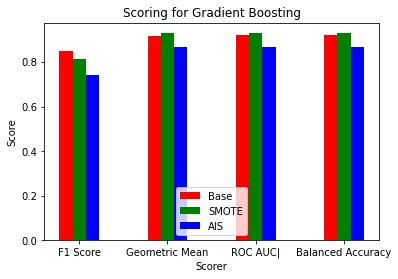

In [7]:
n = 4
ind = np.arange(n)
width = 0.15

xvals = [average_f1_score_GB_Base, average_geometric_mean_score_GB_Base, average_roc_auc_GB_Base, average_balanced_acc_GB_Base]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = [average_f1_score_GB, average_geometric_mean_score_GB, average_roc_auc_GB, average_balanced_acc_GB]
bar2 = plt.bar(ind+width, yvals, width, color = 'g')

zvals = [average_f1_score_GB_AIS, average_geometric_mean_score_GB_AIS, average_roc_auc_GB_AIS, average_balanced_acc_GB_AIS]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

plt.xlabel("Scorer")
plt.ylabel("Score")
plt.title("Scoring for Gradient Boosting")

plt.xticks(ind+width,["F1 Score", "Geometric Mean", "ROC AUC|", "Balanced Accuracy"])
plt.legend((bar1,bar2,bar3), ('Base','SMOTE', 'AIS'))

plt.show()

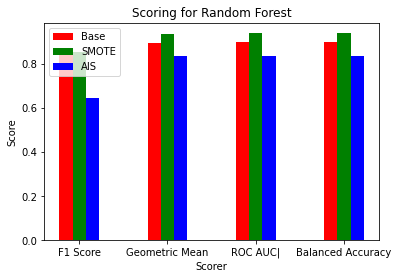

In [8]:
n = 4
ind = np.arange(n)
width = 0.15

xvals = [average_f1_score_RF_Base, average_geometric_mean_score_RF_Base, average_roc_auc_RF_Base, average_balanced_acc_RF_Base]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = [average_f1_score_RF, average_geometric_mean_score_RF, average_roc_auc_RF, average_balanced_acc_RF]
bar2 = plt.bar(ind+width, yvals, width, color = 'g')

zvals = [average_f1_score_RF_AIS, average_geometric_mean_score_RF_AIS, average_roc_auc_RF_AIS, average_balanced_acc_RF_AIS]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

plt.xlabel("Scorer")
plt.ylabel("Score")
plt.title("Scoring for Random Forest")

plt.xticks(ind+width,["F1 Score", "Geometric Mean", "ROC AUC|", "Balanced Accuracy"])
plt.legend((bar1,bar2,bar3), ('Base','SMOTE', 'AIS'))

plt.show()

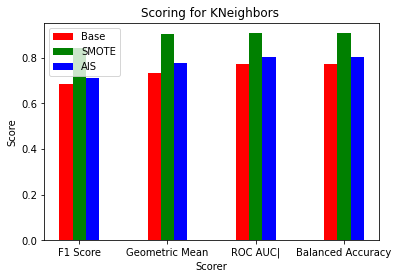

In [9]:
n = 4
ind = np.arange(n)
width = 0.15

xvals = [average_f1_score_KN_Base, average_geometric_mean_score_KN_Base, average_roc_auc_KN_Base, average_balanced_acc_KN_Base]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = [average_f1_score_KN, average_geometric_mean_score_KN, average_roc_auc_KN, average_balanced_acc_KN]
bar2 = plt.bar(ind+width, yvals, width, color = 'g')

zvals = [average_f1_score_KN_AIS, average_geometric_mean_score_KN_AIS, average_roc_auc_KN_AIS, average_balanced_acc_KN_AIS]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

plt.xlabel("Scorer")
plt.ylabel("Score")
plt.title("Scoring for KNeighbors ")

plt.xticks(ind+width,["F1 Score", "Geometric Mean", "ROC AUC|", "Balanced Accuracy"])
plt.legend((bar1,bar2,bar3), ('Base','SMOTE', 'AIS'))

plt.show()

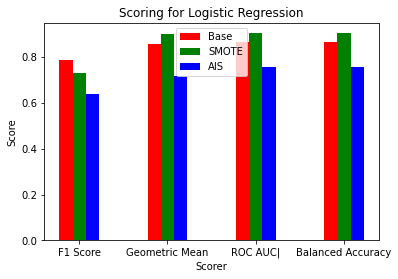

In [10]:
n = 4
ind = np.arange(n)
width = 0.15

xvals = [average_f1_score_LR_Base, average_geometric_mean_score_LR_Base, average_roc_auc_LR_Base, average_balanced_acc_LR_Base]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = [average_f1_score_LR, average_geometric_mean_score_LR, average_roc_auc_LR, average_balanced_acc_LR]
bar2 = plt.bar(ind+width, yvals, width, color = 'g')

zvals = [average_f1_score_LR_AIS, average_geometric_mean_score_LR_AIS, average_roc_auc_LR_AIS, average_balanced_acc_LR_AIS]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')

plt.xlabel("Scorer")
plt.ylabel("Score")
plt.title("Scoring for Logistic Regression")

plt.xticks(ind+width,["F1 Score", "Geometric Mean", "ROC AUC|", "Balanced Accuracy"])
plt.legend((bar1,bar2,bar3), ('Base','SMOTE', 'AIS'))

plt.show()